# Modeling Workflow Example - Greenplum Database


Greenplum Database features used

* Apache MADlib - http://madlib.apache.org/
* Procedural language extension to Python - https://gpdb.docs.pivotal.io/530/ref_guide/extensions/pl_python.html


Example uses Online Retail Data found at UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/online+retail



## Index

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
### Data Loading

* <a href="#download_data">Download Data</a>
* <a href="#import_data">Import Data</a>
* <a href="#cleanup_data">Cleanup Data</a>

### Data Audit

* <a href="#summary_statistics">Summary Statistics</a>
* <a href="#missing_data">Missing Data</a>

### Data Exploration

* <a href="#de_cancellation">Cancellation</a>
* <a href="#de_invoiceno">Invoice No</a>
* <a href="#de_stockcode">Stockcode</a>
* <a href="#de_description">Description</a>
* <a href="#de_quantity">Quantity</a>
* <a href="#de_invoicedate">Invoice Date</a>
* <a href="#de_unitprice">Unit Price</a>
* <a href="#de_customerid">Customer ID</a>
* <a href="#de_country">Country</a>
 
### Feature Engineering



### Model Training



### Model Scoring



### Functions

* <a href="#bar_plot">bar_plot()</a>


## Setup

<a id="dependencies"></a>

In [75]:
# dependencies
import psycopg2
import pandas as pd
import xlrd
import urllib
import re
import seaborn as sns
from matplotlib import pyplot as plt

<a id="package_options"></a>

In [76]:
# package options
%matplotlib inline
%pylab inline

pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="white")

Populating the interactive namespace from numpy and matplotlib


<a id="database_connection"></a>

In [2]:
# database connection
try:
    conn = psycopg2.connect("dbname='gpadmin' user='gpadmin' host='gpdb' password='pivotal'")
    cur = conn.cursor()
    conn.autocommit = True
except:
    print "I am unable to connect to the database"

## Data Loading

In [3]:
# download xlsx file
dls = "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
urllib.urlretrieve(dls, "OnlineRetail.xlsx")

('OnlineRetail.xlsx', <httplib.HTTPMessage instance at 0x7f067ef5ce18>)

In [65]:
# create table shell in gpdb
query = """
    DROP TABLE IF EXISTS public.online_retail_data
"""
cur.execute(query)

ddl = """
    CREATE TABLE public.online_retail_data (
        invoiceno text
       ,stockcode text
       ,description text
       ,quantity float
       ,invoicedate timestamp
       ,unitprice float
       ,customerid text
       ,country text
    ) DISTRIBUTED BY (invoiceno);
"""
cur.execute(ddl)

In [66]:
# check if string contains all acsii characters
def is_ascii(s):
    if isinstance(s, float) or isinstance(s, int):
        return True
    else:
        return all(ord(c) < 128 for c in s)

In [67]:
def xlsx_timestamp_to_gpdb(dt):
    d = xlrd.xldate_as_tuple(dt,0)
    return "{}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}".format(d[0],d[1],d[2],d[3],d[4],d[5])

In [68]:
# function to insert records into existing table
def create_row(types, record):
    rowValues = '';
        
    for i in range(0,len(types)):
        
        # remove non-ascii characters (replaces with whitespace)
        # Example:
        # Dotcomgiftshop Gift Voucher £40.00
        # Dotcomgiftshop Gift Voucher  40.00
        if is_ascii(record[i]) == False:  
            record[i] = re.sub(r'[^\x00-\x7F]+',' ', record[i])
        
        if record[i] == '':
            rowValues = rowValues + ", null"
        else:
            # add single quotes around text fields
            if types[i] in ['text','varchar']:
                rowValues = rowValues + ",$r${}$r$".format(str(record[i]))
            elif types[i] == 'timestamp':
                rowValues = rowValues + ",'{}'".format(xlsx_timestamp_to_gpdb(record[i])) 
            else:
                rowValues = rowValues + ",{}".format(record[i])
            
    return ",({})".format(rowValues[1:])

In [69]:
# load xlsx file into gpdb
def load_xlsx_file(xlsxFilename):
    
    # open workbook
    workbook = xlrd.open_workbook(xlsxFilename)
    sheet = workbook.sheet_by_index(0)
    
    prep_data = ''
    
    # iterate through rows in sheet sheet.nrows
    for r in range(1,sheet.nrows):
        
        rec = sheet.row_values(r)
        
        colTypes = ["text","text","text","float","timestamp","float","text","text"]
        
        prep_data = prep_data + create_row(colTypes,rec)
        
        # batch load N records at a time
        if (r % 1000) == 0:  
            query = """
                INSERT INTO public.online_retail_data VALUES {}
            """.format(prep_data[1:])
            cur.execute(query)
            prep_data = ''
    
    # load any remaining records
    if prep_data != '':
        query = """
              INSERT INTO public.online_retail_data VALUES {}
        """.format(prep_data[1:])
        cur.execute(query)       

    # clean up
    workbook.release_resources()
    del workbook
    
load_xlsx_file("OnlineRetail.xlsx")

In [70]:
# parse cancellation field out of invoiceno
query = """
    DROP TABLE IF EXISTS public.online_retail_data_2;
    CREATE TABLE public.online_retail_data_2 AS
    SELECT CASE WHEN substring(invoiceno,1,1) = 'C' THEN 1 ELSE 0 END AS cancellation
          ,CASE WHEN substring(invoiceno,1,1) = 'C' THEN substring(invoiceno,2,6)
                ELSE substring(invoiceno,1,6)
           END AS invoiceno
          ,stockcode 
          ,description 
          ,quantity 
          ,invoicedate
          ,unitprice 
          ,customerid 
          ,country 
    FROM public.online_retail_data
    DISTRIBUTED BY (invoiceno);
    DROP TABLE public.online_retail_data;
    ALTER TABLE public.online_retail_data_2 RENAME TO online_retail_data;
"""

cur.execute(query)

In [71]:
query = """
    SELECT cancellation
          ,invoiceno
          ,stockcode 
          ,description 
          ,quantity 
          ,invoicedate
          ,unitprice 
          ,customerid 
          ,country 
    FROM public.online_retail_data
    LIMIT 10
"""
cur.execute(query)
pd.DataFrame(cur.fetchall())

,0,1,2,3,4,5,6,7,8
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,0,536365,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,0,536365,22752.0,SET 7 BABUSHKA NESTING BOXES,2.0,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,0,536365,21730.0,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,0,536367,84879.0,ASSORTED COLOUR BIRD ORNAMENT,32.0,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
8,0,536367,22745.0,POPPY'S PLAYHOUSE BEDROOM,6.0,2010-12-01 08:34:00,2.10,13047.0,United Kingdom
9,0,536367,22748.0,POPPY'S PLAYHOUSE KITCHEN,6.0,2010-12-01 08:34:00,2.10,13047.0,United Kingdom


In [72]:
query = """
    SELECT count(*)
    FROM public.online_retail_data
"""
cur.execute(query)
pd.DataFrame(cur.fetchall())

,0
0,541909


## Data Audit

<a id="summary_statistics"></a>
Summary Statistics

In [73]:
# drop existing table
query = """
    DROP TABLE IF EXISTS public.online_retail_summary;
"""
cur.execute(query)

# run madlib summary stats function
query = """
    SELECT madlib.summary('public.online_retail_data','public.online_retail_summary');
"""
cur.execute(query)

# grab results from gpdb
query = """
    SELECT * FROM public.online_retail_summary;
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
or_summary = pd.DataFrame(cur.fetchall(), columns=colnames)

In [74]:
or_summary

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,cancellation,1,int4,541909,2,0,NaN,0.000000,NaN,0.017139,0.016846,0.00,1.0,0.00,0.00,0.00,"[0, 0, 1, 1]","[532621, 532621, 9288, 9288]"
1,None,None,invoiceno,2,text,541909,26376,0,0.0,0.000000,0.000000,NaN,NaN,6.00,6.0,NaN,NaN,NaN,"[573585, 580729, 579777, 581219, 581492, 58073...","[1421, 1203, 1095, 1070, 1029, 979, 969, 943, ..."
2,None,None,stockcode,3,text,541909,4070,0,0.0,0.000000,0.000000,NaN,NaN,1.00,12.0,NaN,NaN,NaN,"[85123A, 85123A, 22423.0, 22423.0, 85099B, 850...","[2324, 2324, 2203, 2203, 2166, 2166, 1808, 180..."
3,None,None,description,4,text,541909,4223,1454,55.0,0.002683,0.000101,NaN,NaN,1.00,35.0,NaN,NaN,NaN,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE HAN...","[2449, 2449, 2243, 2243, 2208, 2208, 1737, 173..."
4,None,None,quantity,5,float8,541909,722,0,NaN,0.000000,NaN,9.552250,47559.391409,-80995.00,80995.0,1.00,3.00,10.00,"[1, 1, 2, 2, 12, 12, 6, 6, 4, 4]","[148227, 148227, 81829, 81829, 61063, 61063, 4..."
5,None,None,invoicedate,6,timestamp,541909,23414,0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2011-10-31 14:41:00, 2011-12-08 09:28:00, 201...","[1314, 1092, 1050, 1045, 1042, 1038, 1037, 102..."
6,None,None,unitprice,7,float8,541909,1630,0,NaN,0.000000,NaN,4.611114,9362.469164,-11062.06,38970.0,1.25,2.08,4.13,"[1.25, 1.25, 1.65, 1.65, 0.85, 0.85, 2.95, 2.9...","[50496, 50496, 38182, 38182, 28497, 28497, 277..."
7,None,None,customerid,8,text,541909,4372,135080,0.0,0.249267,0.000000,NaN,NaN,7.00,7.0,NaN,NaN,NaN,"[17841.0, 17841.0, 14911.0, 14911.0, 14096.0, ...","[7983, 7983, 5903, 5903, 5192, 5192, 4642, 464..."
8,None,None,country,9,text,541909,38,0,0.0,0.000000,0.000000,NaN,NaN,3.00,20.0,NaN,NaN,NaN,"[United Kingdom, United Kingdom, Germany, Germ...","[495478, 495478, 9495, 9495, 8557, 8557, 8196,..."


<a id="missing_data"></a>

Missing data

<a id="bar_plot"></a>

In [80]:
def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

    # add 1000s commas
    #plt.get_yaxis().set_major_formatter(
    #    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

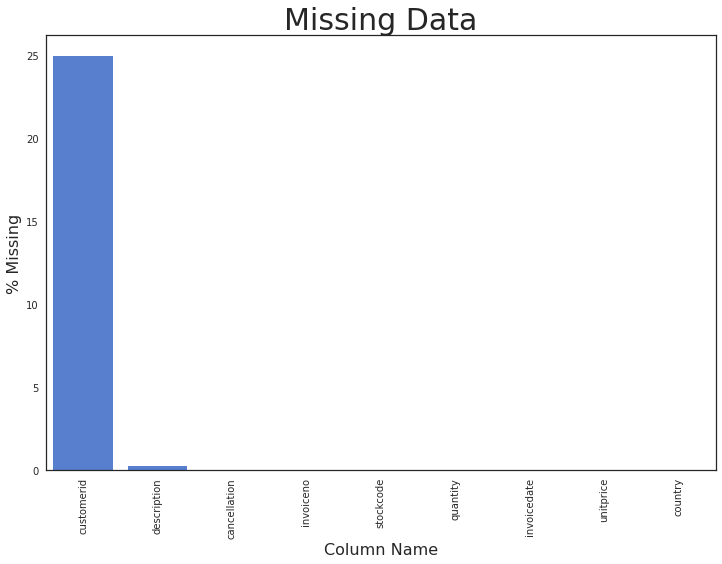

In [84]:
missing_counts = or_summary.sort_values('missing_values',ascending=False)
missing_counts['perc_missing'] = missing_counts['fraction_missing'] * 100.0
bar_plot(missing_counts,"Missing Data","target_column","Column Name","perc_missing","% Missing", "#4378E2")

## Data Exploration

In [ ]:
def bar_plot_groupby(data,title,x,xLabel,y,yLabel,groupby,color=None,axisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color, hue=groupby)
    else:
        plt = sns.barplot(x=x, y=y, data=data, hue=groupby)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(axisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

    # add 1000s commas
    plt.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

In [ ]:
* <a href="#de_cancellation">Cancellation</a>
* <a href="#de_invoiceno">Invoice No</a>
* <a href="#de_stockcode">Stockcode</a>
* <a href="#de_description">Description</a>
* <a href="#de_quantity">Quantity</a>
* <a href="#de_invoicedate">Invoice Date</a>
* <a href="#de_unitprice">Unit Price</a>
* <a href="#de_customerid">Customer ID</a>
* <a href="#de_country">Country</a>

<a id="de_cancellation"></a>
#### Cancellation

In [ ]:
<a id="de_invoiceno"></a>
#### Invoice No

In [ ]:
<a id="de_stockcode"></a>
#### Stockcode

In [ ]:
<a id="de_description"></a>
#### Description

In [ ]:
<a id="de_quantity"></a>
#### Quantity

In [ ]:
<a id="de_invoicedate"></a>
#### Invoice Date

In [ ]:
<a id="de_unitprice"></a>
#### Unit Price

In [ ]:
<a id="de_customerid"></a>
#### Customer ID

In [ ]:
<a id="de_country"></a>
#### Country

## Feature Engineering

## Model Training

## Model Scoring